In [15]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np

from mpc.dynamics import AffineDynamics
from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
import torch
from torch.autograd import Function, Variable
from torch.nn.parameter import Parameter
import torch.optim as optim

import matplotlib.pyplot as plt

%matplotlib inline

from controllers import DeePC
plt.rcParams["figure.figsize"] = (15,5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
B = np.eye(3) # B - State-space matrix
C = np.eye(3) # C - State-space matrix
D = np.zeros([3,3]) # D - State-space matrix
n = A.shape[0] # n = number of states
m = B.shape[1] # m = number of inputs
p = C.shape[0] # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1                           

ud shape : (67, 3), yd shape : (67, 3)


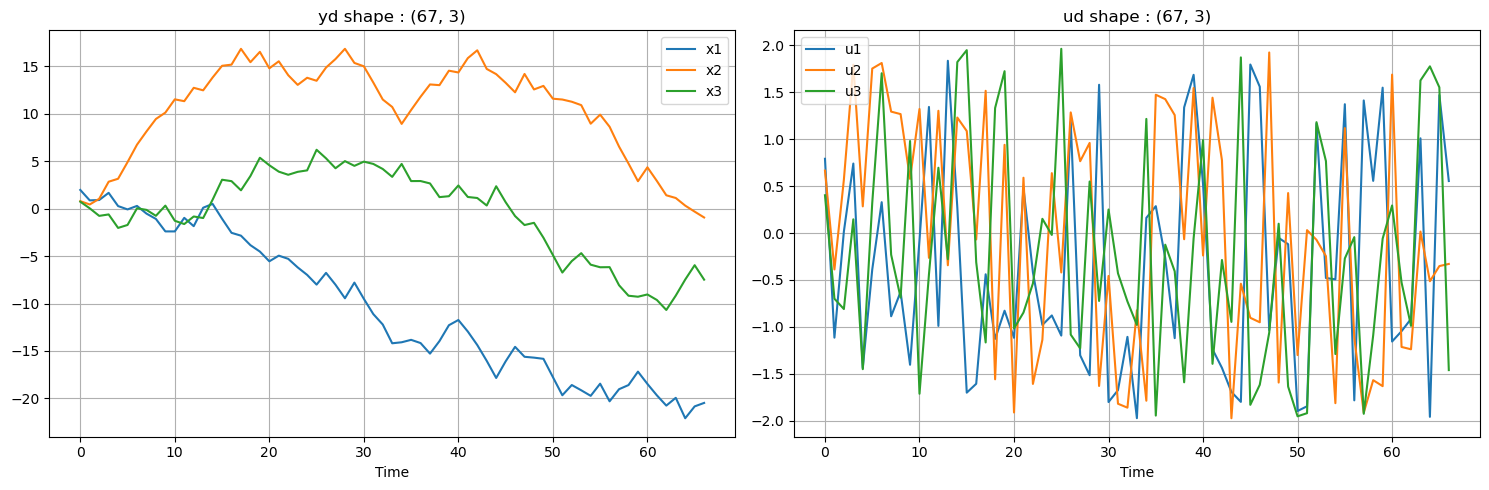

In [17]:
ud = []
yd = []
x = np.random.uniform(low=-2, high=2, size=(m,)) # Random initial condition
for i in range(T):
   u = np.random.uniform(low=-2, high=2, size=(m,)) # Random input
   x = A@x + B@u
   y = C@x + D@u
   ud.append(u)
   yd.append(y + np.random.randn(p,)*0.01) 
ud = np.array(ud)
yd = np.array(yd)

print(f'ud shape : {ud.shape}, yd shape : {yd.shape}')
plt.subplot(1,2,1)
plt.plot(range(0,T), yd, label=['x1', 'x2', 'x3'])
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yd.shape}")
plt.grid(True)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), ud, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {ud.shape}")
plt.grid(True)
plt.tight_layout()

plt.show()

ud = ud.reshape((T*m,))
yd = yd.reshape((T*p,))

In [19]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([4,4,4]))
u_constraonts = np.kron(np.ones(Tf), np.array([2,2,2]))
R = np.eye(m)*0.1
Q = np.eye(p)*10

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_constraints, u_constraints=u_constraonts,
    N=Tf, Tini=Tini, n=n, T=T, p=p, m=m
)

In [14]:
def imitaion_loss(q_est, r_est) -> torch.Tensor:

    # Expert
    expert = controller.setup()
    Q_est = np.diag(q_est)
    R_est = np.diag(r_est)


SyntaxError: expected ':' (3221783270.py, line 1)